
[INFO] Running compare_analysis_results in standalone mode...

Connected to database quantummusic_csef.
Database connection closed.
=== MASTER–STUDENT COMPARISON RESULTS ===

--- Classical Features ---
avg_pitch_hz: {'master': 175.1198390908512, 'student': 175.0365147881974, 'difference': 0.08332430265380708}
avg_jitter: {'master': 0.007377981574698159, 'student': 0.0075758215451885835, 'difference': 0.00019783997049042414}
avg_shimmer: {'master': 0.06623620589889583, 'student': 0.08033137309240909, 'difference': 0.014095167193513267}
avg_tempo_bpm: {'master': 139.5854897679418, 'student': 139.60437396845347, 'difference': 0.018884200511678273}
avg_lufs: {'master': -18.53008964552012, 'student': -25.632292366160655, 'difference': 7.102202720640534}
comment: Classical features derived from time_matrix_small (averaged).

--- Quantum Features ---
=== Quantum Master–Student Comparison ===
Jensen–Shannon distance: 0.5860
Scaled angles Euclidean distance: 2.4302
Master Shannon entropy: 7.88

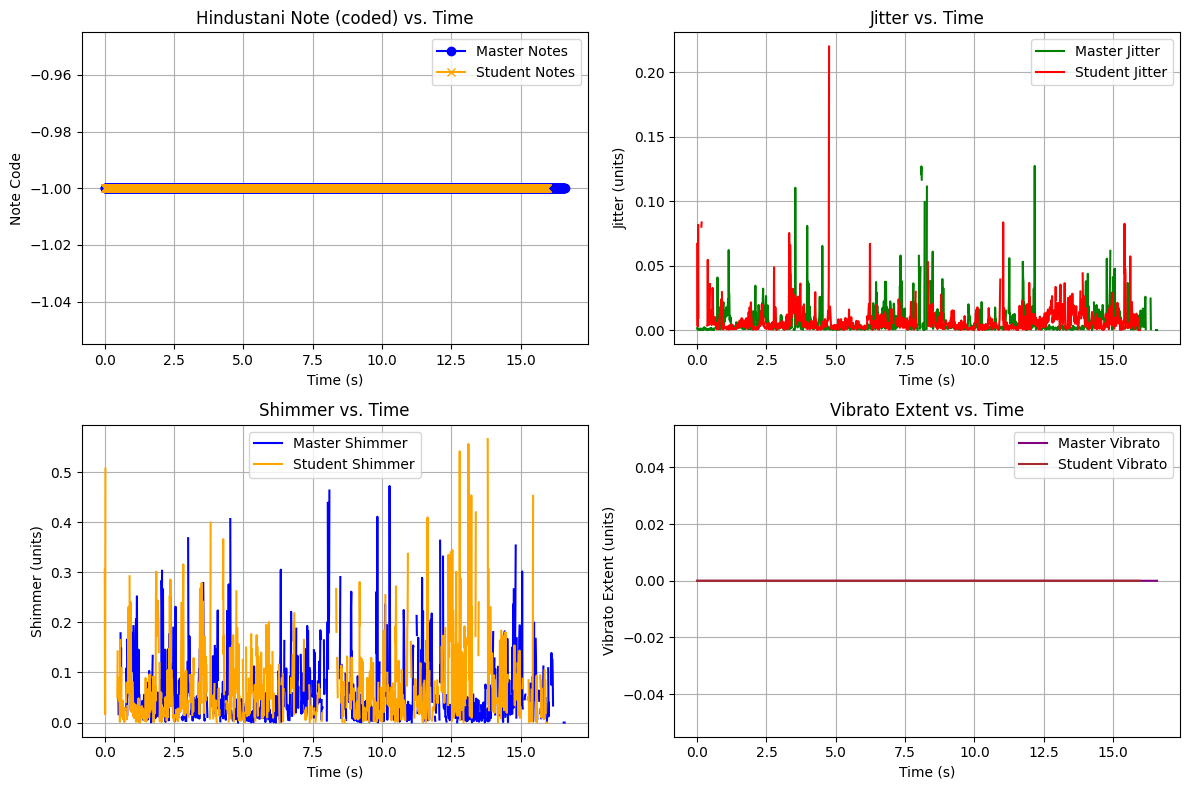

[INFO] time_matrix_small comparisons plot stored as base64 under analysis_student['master_comparison']['plots']['time_matrix_small_comparison']

Done.



<Figure size 640x480 with 0 Axes>

In [6]:
#!/usr/bin/env python3
# complete_compare.py

import os
import math
import psycopg2
from psycopg2.extras import Json
import numpy as np
import base64
import io
import matplotlib.pyplot as plt

# 1) Minimal Database Class

class QuantumMusicDB:
    """
    Minimal class to connect to a PostgreSQL database and fetch a single row
    from the 'audio_analysis' table.
    """

    def __init__(self,
                 db_name="quantummusic_csef",
                 host="localhost",
                 user="postgres",
                 password="postgres"):
        self.db_name = db_name
        self.host = host
        self.user = user
        self.password = password
        self.conn = None
        self.connect()

    def connect(self):
        try:
            self.conn = psycopg2.connect(
                dbname=self.db_name,
                host=self.host,
                user=self.user,
                password=self.password
            )
            print(f"Connected to database {self.db_name}.")
        except Exception as e:
            print(f"Error connecting to database: {e}")

    def close(self):
        if self.conn:
            self.conn.close()
            print("Database connection closed.")

    def fetch_analysis(self, record_id):
        """
        Expects to find a row (id, file_name, sample_rate, analysis_data)
        in 'audio_analysis'. Returns that row or None if not found.
        """
        with self.conn.cursor() as cur:
            query = """
                SELECT id, file_name, sample_rate, analysis_data
                FROM audio_analysis
                WHERE id = %s
            """
            cur.execute(query, (record_id,))
            row = cur.fetchone()
        return row



# 2) Helper Functions for Quantum Comparisons

def _counts_to_probability(measure_counts):
    total_shots = sum(measure_counts.values())
    if total_shots == 0:
        return {}
    return {state: c / total_shots for (state, c) in measure_counts.items()}

def _kl_div(p, q):
    div = 0.0
    for key, p_val in p.items():
        if p_val > 0:
            q_val = q.get(key, 0.0)
            if q_val > 0:
                div += p_val * math.log2(p_val / q_val)
    return div

def _js_distance(p, q):
    all_keys = set(p.keys()) | set(q.keys())
    m = {}
    for key in all_keys:
        p_val = p.get(key, 0.0)
        q_val = q.get(key, 0.0)
        m[key] = 0.5 * (p_val + q_val)

    js_div = 0.5 * _kl_div(p, m) + 0.5 * _kl_div(q, m)
    return math.sqrt(js_div)

def _euclidean_distance(v1, v2):
    n = min(len(v1), len(v2))
    dist_sq = 0.0
    for i in range(n):
        diff = (v1[i] - v2[i])
        dist_sq += diff * diff
    return math.sqrt(dist_sq)

def _compare_bitstring_probabilities(p1, p2, top_n=5):
    all_keys = set(p1.keys()) | set(p2.keys())
    diffs = []
    for bs in all_keys:
        val1 = p1.get(bs, 0.0)
        val2 = p2.get(bs, 0.0)
        diff = abs(val1 - val2)
        diffs.append((bs, val1, val2, diff))
    diffs.sort(key=lambda x: x[3], reverse=True)
    return diffs[:top_n]

def _compare_scaled_angles(angles1, angles2, top_n=5):
    n = min(len(angles1), len(angles2))
    diffs = []
    for i in range(n):
        a1 = angles1[i]
        a2 = angles2[i]
        diff = abs(a1 - a2)
        diffs.append((i, a1, a2, diff))
    diffs.sort(key=lambda x: x[3], reverse=True)
    return diffs[:top_n]

def _compare_advanced_stats(adv_stats_1, adv_stats_2):
    all_stats = set(adv_stats_1.keys()) | set(adv_stats_2.keys())
    diffs = []
    for stat in all_stats:
        val1 = adv_stats_1.get(stat, 0.0)
        val2 = adv_stats_2.get(stat, 0.0)
        diff = abs(val1 - val2)
        if diff > 0:
            diffs.append((stat, val1, val2, diff))
    diffs.sort(key=lambda x: x[3], reverse=True)
    return diffs

def _shannon_entropy(prob_dict):
    """
    Computes the Shannon entropy (in bits) of a probability distribution stored
    in `prob_dict`. The dictionary keys are bitstrings; values are probabilities.
    """
    import math
    entropy = 0.0
    for p in prob_dict.values():
        if p > 0:
            entropy -= p * math.log2(p)
    return entropy


import math
import cmath

def _perform_qft(prob_dict, num_qubits=10):
    """
    1. Convert a probability dict (bitstring -> probability) into a complex statevector.
       Each amplitude is sqrt(prob).
    2. Apply a naive QFT on the statevector.
    3. Return a new dictionary of bitstring -> probability after QFT.
    """
    # Step 1: Build amplitude vector of length 2^num_qubits
    dim = 2 ** num_qubits
    state_vec = [0.0+0.0j] * dim

    # Populate amplitudes from prob_dict
    # e.g. if prob_dict["000101"] = 0.05, amplitude is sqrt(0.05)
    # Make sure to align bitstring length w/ num_qubits (pad/truncate).
    for bitstring, p in prob_dict.items():
        if p <= 0:
            continue
        bs = bitstring[-num_qubits:]  # if bitstring is longer, take rightmost bits
        bs = bs.rjust(num_qubits, '0')  # if shorter, pad with leading zeros
        idx = int(bs, 2)
        amp = math.sqrt(p)
        state_vec[idx] = amp + 0.0j

    # Step 2: Naive QFT on the amplitude vector.
    # QFT transform: for each k, the new amplitude is the sum of e^(2πi * j*k / N)* old_amp_j
    # where N=2^num_qubits.
    # We'll do a direct O(N^2) approach for clarity.
    N = dim
    out_vec = [0.0+0.0j] * N
    for k in range(N):
        accum = 0.0 + 0.0j
        for j in range(N):
            phase = 2 * math.pi * j * k / N
            accum += state_vec[j] * cmath.exp(1j * phase)
        out_vec[k] = accum / math.sqrt(N)

    # Step 3: Convert the new amplitude vector back to a probability dict
    # Probability is abs^2 of amplitude
    new_prob_dict = {}
    for i, amp in enumerate(out_vec):
        new_p = abs(amp)**2
        if new_p > 0:
            # Convert i -> bitstring
            bs = format(i, '0{}b'.format(num_qubits))
            new_prob_dict[bs] = new_p

    return new_prob_dict



# 3) FEEDBACK CONSOLIDATION & ACTIONABLE SUMMARY

def consolidate_feedback_items(feedback_list, max_time_gap=1.0):
    if not feedback_list:
        return []
    sorted_items = sorted(feedback_list, key=lambda f: f.get("start_time", 0.0))
    consolidated = []
    current_group = [sorted_items[0]]

    for item in sorted_items[1:]:
        prev_item = current_group[-1]
        gap = item["start_time"] - prev_item["end_time"]
        if gap <= max_time_gap:
            current_group.append(item)
        else:
            consolidated.append(_merge_feedback_group(current_group))
            current_group = [item]

    if current_group:
        consolidated.append(_merge_feedback_group(current_group))

    return consolidated

def _merge_feedback_group(group):
    start_times = [f["start_time"] for f in group]
    end_times = [f["end_time"] for f in group]
    min_start = min(start_times)
    max_end = max(end_times)

    issues = []
    for f in group:
        issues.append(f"({f['start_time']:.2f}-{f['end_time']:.2f}s) {f['issue']}")
    combined_issues = " | ".join(issues)

    severity_levels = [f.get("severity", "medium") for f in group]
    final_severity = max(severity_levels)

    return {
        "start_time": min_start,
        "end_time": max_end,
        "issue": combined_issues,
        "severity": final_severity
    }

def generate_actionable_feedback(analysis_dict):
    raw_items = analysis_dict.get("raw_feedback_items", [])
    consolidated = consolidate_feedback_items(raw_items, max_time_gap=1.0)
    consolidated.sort(key=lambda x: x.get("severity", "medium"), reverse=True)

    top_segments = consolidated[:4]
    bullet_points = []
    for seg in top_segments:
        msg = (f"Time {seg['start_time']:.2f}-{seg['end_time']:.2f}s: {seg['issue']}. "
               f"Severity: {seg['severity']}. Focus on consistent performance.")
        bullet_points.append(msg)

    if len(consolidated) > 4:
        bullet_points.append("Additional issues exist but are omitted for brevity.")

    analysis_dict["actionable_feedback"] = bullet_points
    return bullet_points



# 4) CLASSICAL FEATURE COMPARISON
def compare_classical_features(analysis_master, analysis_student):
    """
    In the new JSON, we gather classical metrics from analysis_dict["time_matrix_small"].
    We'll compute average pitch, jitter, shimmer, tempo, etc. across all chunks.
    """

    master_tms = (analysis_master
               .get("time_matrices", {})
               .get("time_matrix_tempo_large", []))
    student_tms = (analysis_student
               .get("time_matrices", {})
                .get("time_matrix_tempo_large", []))
    # Graceful fallback if missing
    if not master_tms or not student_tms:
        if "master_comparison" not in analysis_student:
            analysis_student["master_comparison"] = {}
        analysis_student["master_comparison"]["classical"] = {
            "message": "Missing time_matrix in master or student."
        }
        return analysis_student["master_comparison"]["classical"]

    # Helper to compute the average of a given key across time_matrix_small
    def avg_metric(tmatrix, key):
        vals = [chunk.get(key, 0.0) for chunk in tmatrix]
        if vals:
            return float(np.mean(vals))
        return 0.0

    # Example metrics:
    master_pitch = avg_metric(master_tms, "avg_pitch_hz")
    student_pitch = avg_metric(student_tms, "avg_pitch_hz")
    pitch_diff = abs(master_pitch - student_pitch)

    master_jitter = avg_metric(master_tms, "avg_jitter")
    student_jitter = avg_metric(student_tms, "avg_jitter")

    master_shimmer = avg_metric(master_tms, "avg_shimmer")
    student_shimmer = avg_metric(student_tms, "avg_shimmer")

    master_tempo = avg_metric(master_tms, "avg_tempo_bpm")
    student_tempo = avg_metric(student_tms, "avg_tempo_bpm")
    tempo_diff = abs(master_tempo - student_tempo)

    master_lufs = avg_metric(master_tms, "lufs")
    student_lufs = avg_metric(student_tms, "lufs")
    lufs_diff = abs(master_lufs - student_lufs)

    classical_comp = {
        "avg_pitch_hz": {
            "master": master_pitch,
            "student": student_pitch,
            "difference": pitch_diff
        },
        "avg_jitter": {
            "master": master_jitter,
            "student": student_jitter,
            "difference": abs(master_jitter - student_jitter)
        },
        "avg_shimmer": {
            "master": master_shimmer,
            "student": student_shimmer,
            "difference": abs(master_shimmer - student_shimmer)
        },
        "avg_tempo_bpm": {
            "master": master_tempo,
            "student": student_tempo,
            "difference": tempo_diff
        },
        "avg_lufs": {
            "master": master_lufs,
            "student": student_lufs,
            "difference": lufs_diff
        },
        "comment": "Classical features derived from time_matrix_small (averaged)."
    }

    if "master_comparison" not in analysis_student:
        analysis_student["master_comparison"] = {}
    analysis_student["master_comparison"]["classical"] = classical_comp
    return classical_comp



# 5) QUANTUM FEATURE COMPARISON

def compare_quantum_features(analysis_master, analysis_student, top_n=5):
    """
    Compare the quantum analysis from 'analysis_master' and 'analysis_student',
    referencing the new JSON keys:
      - measurement_counts
      - scaled_angles
      - circuit_diagram
      - feature_vector (unused in direct comparisons, but we can log it if needed)
    Returns a dict summarizing quantum-level differences, stored in:
      analysis_student["master_comparison"]["quantum"].
    """

    qa1 = analysis_master.get("quantum_analysis", {})
    qa2 = analysis_student.get("quantum_analysis", {})

    # If one or both are missing quantum_analysis, store a simple message and bail.
    if not qa1 or not qa2:
        if "master_comparison" not in analysis_student:
            analysis_student["master_comparison"] = {}
        analysis_student["master_comparison"]["quantum"] = {
            "quantum_summary": "Missing quantum data in one or both recordings."
        }
        return analysis_student["master_comparison"]["quantum"]

    # 1) Extract measurement counts & convert to probabilities
    mc1 = qa1.get("measurement_counts", {})
    mc2 = qa2.get("measurement_counts", {})
    p1 = _counts_to_probability(mc1)
    p2 = _counts_to_probability(mc2)

    # 2) Jensen–Shannon distance & bitstring differences
    js_dist = _js_distance(p1, p2)
    bitstring_diffs = _compare_bitstring_probabilities(p1, p2, top_n=top_n)

    # 3) Scaled angle arrays & Euclidean distance
    angles1 = qa1.get("scaled_angles", [])
    angles2 = qa2.get("scaled_angles", [])
    angle_dist = _euclidean_distance(angles1, angles2)
    angle_diffs = _compare_scaled_angles(angles1, angles2, top_n=top_n)

    # 4) Optional QFT-based comparison
    qft_p1 = _perform_qft(p1, num_qubits=10)  # or whatever # qubits you normally assume
    qft_p2 = _perform_qft(p2, num_qubits=10)
    qft_js_dist = _js_distance(qft_p1, qft_p2)

    # 5) Shannon entropy difference
    master_entropy = _shannon_entropy(p1)
    student_entropy = _shannon_entropy(p2)
    entropy_diff = abs(master_entropy - student_entropy)

    # 6) If you used advanced stats in older code, you can keep it:
    adv_stats_1 = qa1.get("advanced_stats", {})
    adv_stats_2 = qa2.get("advanced_stats", {})
    adv_stat_diffs = _compare_advanced_stats(adv_stats_1, adv_stats_2)

    # 7) Build a textual summary for the results
    summary_lines = [
        "=== Quantum Master–Student Comparison ===",
        f"Jensen–Shannon distance: {js_dist:.4f}",
        f"Scaled angles Euclidean distance: {angle_dist:.4f}",
        f"Master Shannon entropy: {master_entropy:.4f}",
        f"Student Shannon entropy: {student_entropy:.4f}",
        f"Entropy difference: {entropy_diff:.4f}",
        f"QFT-based JS distance: {qft_js_dist:.4f}",
        "Lower => more similar.\n",
        "Top Bitstring Probability Differences:"
    ]
    for i, (bs, val1, val2, diff) in enumerate(bitstring_diffs, 1):
        summary_lines.append(
            f"  {i}) {bs}: master={val1:.4f}, student={val2:.4f}, diff={diff:.4f}"
        )

    summary_lines.append("\nLargest Scaled Angle Differences:")
    for i, (idx, a1, a2, d) in enumerate(angle_diffs, 1):
        summary_lines.append(
            f"  {i}) Angle {idx}: master={a1:.4f}, student={a2:.4f}, diff={d:.4f}"
        )

    if adv_stat_diffs:
        summary_lines.append("\nAdvanced Stats Differences:")
        for stat_name, v1, v2, diff in adv_stat_diffs:
            summary_lines.append(
                f"  {stat_name}: master={v1:.4f}, student={v2:.4f}, diff={diff:.4f}"
            )
    else:
        summary_lines.append("\nNo advanced stats differences found (or not present).")

    # 8) Package results into a dictionary & store in analysis_student
    quantum_results = {
        "quantum_js_distance": js_dist,
        "angle_distance": angle_dist,
        "master_entropy": master_entropy,
        "student_entropy": student_entropy,
        "entropy_diff": entropy_diff,
        "bitstring_differences": bitstring_diffs,
        "angle_differences": angle_diffs,
        "advanced_stat_differences": adv_stat_diffs,
        "qft_js_distance": qft_js_dist,
        "quantum_summary": "\n".join(summary_lines)
    }

    if "master_comparison" not in analysis_student:
        analysis_student["master_comparison"] = {}
    analysis_student["master_comparison"]["quantum"] = quantum_results

    return quantum_results


# 6) PITCH CONTOUR COMPARISON

def compare_pitch_contours(analysis_master, analysis_student, pitch_tolerance_cents=50.0):
    """
    With the new JSON, pitch data lives in analysis_dict["pitch_analysis"],
    specifically 'times_small' and 'pitch_small'.

    This replaces the old "pitch_contour -> times/pitches" references.
    """

    master_pc = (analysis_master
             .get("time_matrices", {})
              .get("time_matrix_small", []))
    student_pc = (analysis_student
              .get("time_matrices", {})
              .get("time_matrix_small", []))


    if not master_pc or not student_pc:
        if "master_comparison" not in analysis_student:
            analysis_student["master_comparison"] = {}
        analysis_student["master_comparison"]["pitch_contours"] = {
            "message": "No pitch_analysis data in master or student."
        }
        return

    times_m = [row.get("time_s", 0.0) for row in master_pc]
    pitches_m = [row.get("pitch_hz", 0.0) for row in master_pc]
    times_s = [row.get("time_s", 0.0) for row in student_pc]
    pitches_s = [row.get("pitch_hz", 0.0) for row in student_pc]

    n = min(len(times_m), len(times_s), len(pitches_m), len(pitches_s))
    if n == 0:
        analysis_student["master_comparison"]["pitch_contours"] = {
            "message": "Pitch contour arrays exist but are empty."
        }
        return

    major_deviations = []
    in_deviation = False
    start_dev_idx = 0

    for i in range(n):
        diff = abs(pitches_m[i] - pitches_s[i])
        if diff > pitch_tolerance_cents:
            if not in_deviation:
                in_deviation = True
                start_dev_idx = i
        else:
            if in_deviation:
                end_dev_idx = i - 1
                avg_diff = float(np.mean(np.abs(
                    np.array(pitches_m[start_dev_idx:end_dev_idx+1]) -
                    np.array(pitches_s[start_dev_idx:end_dev_idx+1])
                )))
                major_deviations.append({
                    "start_time": times_m[start_dev_idx],
                    "end_time": times_m[end_dev_idx],
                    "average_diff_cents": avg_diff
                })
                in_deviation = False

    if in_deviation:
        end_dev_idx = n - 1
        avg_diff = float(np.mean(np.abs(
            np.array(pitches_m[start_dev_idx:end_dev_idx+1]) -
            np.array(pitches_s[start_dev_idx:end_dev_idx+1])
        )))
        major_deviations.append({
            "start_time": times_m[start_dev_idx],
            "end_time": times_m[end_dev_idx],
            "average_diff_cents": avg_diff
        })

    pitch_contour_result = {
        "num_deviations": len(major_deviations),
        "pitch_tolerance_cents": pitch_tolerance_cents,
        "deviation_regions": major_deviations
    }

    if "master_comparison" not in analysis_student:
        analysis_student["master_comparison"] = {}
    analysis_student["master_comparison"]["pitch_contours"] = pitch_contour_result




# 7) ADDITIONAL PLOTTING FUNCTIONS

def plot_energy_formants_comparison(analysis_master, analysis_student):
    """
    Plot RMS, LUFS, and formant data (F1, F2).
    """
    dyn_m = analysis_master.get("dynamics_summary", {})
    dyn_s = analysis_student.get("dynamics_summary", {})
    rms_m = dyn_m.get("rms_db", {}).get("time_series", [])
    rms_s = dyn_s.get("rms_db", {}).get("time_series", [])
    lufs_m = dyn_m.get("lufs", {}).get("time_series", [])
    lufs_s = dyn_s.get("lufs", {}).get("time_series", [])

    adv_m = analysis_master.get("quantum_analysis", {}).get("advanced_stats", {})
    adv_s = analysis_student.get("quantum_analysis", {}).get("advanced_stats", {})
    f1_m = adv_m.get("time_series_F1", [])
    f1_s = adv_s.get("time_series_F1", [])
    f2_m = adv_m.get("time_series_F2", [])
    f2_s = adv_s.get("time_series_F2", [])

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # RMS
    axs[0, 0].plot(rms_m, label="Master RMS (dB)", color="blue")
    axs[0, 0].plot(rms_s, label="Student RMS (dB)", color="orange")
    axs[0, 0].set_title("RMS (dB)")
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    # LUFS
    axs[0, 1].plot(lufs_m, label="Master LUFS", color="blue")
    axs[0, 1].plot(lufs_s, label="Student LUFS", color="orange")
    axs[0, 1].set_title("LUFS")
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    # F1
    axs[1, 0].plot(f1_m, label="Master F1", color="green")
    axs[1, 0].plot(f1_s, label="Student F1", color="red")
    axs[1, 0].set_title("Formant F1")
    axs[1, 0].grid(True)
    axs[1, 0].legend()

    # F2
    axs[1, 1].plot(f2_m, label="Master F2", color="green", linestyle="--")
    axs[1, 1].plot(f2_s, label="Student F2", color="red", linestyle="--")
    axs[1, 1].set_title("Formant F2")
    axs[1, 1].grid(True)
    axs[1, 1].legend()

    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    plt.close(fig)
    buf.seek(0)
    b64_str = base64.b64encode(buf.read()).decode("utf-8")

    if "master_comparison" not in analysis_student:
        analysis_student["master_comparison"] = {}
    if "plots" not in analysis_student["master_comparison"]:
        analysis_student["master_comparison"]["plots"] = {}
    analysis_student["master_comparison"]["plots"]["energy_formants"] = b64_str


# 8) NEW PLOT: PITCH & NOTE FREQUENCY

def plot_pitch_and_notefreq(analysis_student, output_dir, base_name):
    """
    Uses user-provided code snippet to plot times_small vs pitch_small & note_freq_small.
    Saves to disk as a PNG. The user snippet references:
        plt.plot(times_small, pitch_small)
        plt.plot(times_small, note_freq_small)
    We'll assume the arrays are stored in analysis_student["pitch_analysis"].
    """

    pitch_info = analysis_student.get("time_matrices", {}).get("time_matrix_small", [])
    times_small = [frame.get("time_s", 0.0) for frame in pitch_info]
    pitch_small = [frame.get("pitch_hz", 0.0) for frame in pitch_info]
    note_freq_small = [frame.get("note_freq_hz", 0.0) for frame in pitch_info]
    # If no data, skip
    if not times_small or not pitch_small or not note_freq_small:
        print("[WARN] Missing times_small/pitch_small/note_freq_small. Not plotting pitch vs note freq.")
        return

    # Ensure output directory
    os.makedirs(output_dir, exist_ok=True)

    plt.figure()
    plt.plot(times_small, pitch_small, label='Pitch (Hz)', color='b')
    plt.plot(times_small, note_freq_small, label='NoteFreq (Hz)', color='orange', alpha=0.7)
    plt.ylabel('Frequency (Hz)')
    plt.title('Pitch & Note Frequency')
    plt.legend()

    pitch_filename = os.path.join(output_dir, f"{base_name}_pitch_note_freq.png")
    plt.savefig(pitch_filename)
    plt.close()
    print(f"[INFO] Saved pitch & note freq plot to {pitch_filename}")



import base64
import io
import matplotlib.pyplot as plt

def plot_time_matrix_small_comparisons(analysis_master, analysis_student):
    """
    Reads 'time_matrix_small' arrays from both master & student.
    Generates 4 subplots:
      1) pyin_hindustani_note_standard vs. time
      2) Jitter vs. time
      3) Shimmer vs. time
      4) Vibrato extent vs. time
    for both Master and Student.

    Saves base64-encoded PNG in:
      analysis_student["master_comparison"]["plots"]["time_matrix_small_comparison"]
    """

    # Pull time_matrix_small from each analysis
    tms_master = analysis_master.get("time_matrices", {}).get("time_matrix_small", [])
    tms_student = analysis_student.get("time_matrices", {}).get("time_matrix_small", [])

    # If either is missing or empty, skip
    if not tms_master or not tms_student:
        print("[WARN] Missing 'time_matrix_small' in master or student. Skipping time_matrix_small comparisons.")
        return

    # Extract arrays for Master
    times_m = []
    notes_m = []
    jitter_m = []
    shimmer_m = []
    vibrato_m = []

    # Convert Hindustani note standard from string to numeric code so we can plot
    # Example mapping:  (Feel free to adjust if you have a different note set)
    note_map = {
        "S": 0,  "r": 1,  "R": 2,  "g": 3,  "G": 4,  "m": 5,  "M": 6,
        "P": 7,  "d": 8,  "D": 9,  "n": 10, "N": 11, "Sa": 12
    }
    # A helper to safely map a note string to a numeric code
    def note_to_code(n):
        # If note not in map, just pick -1
        return note_map.get(n, -1)

    for entry in tms_master:
        # Each entry is a dict with keys like "time_s", "pyin_hindustani_note_standard", "jitter", "shimmer", "vibrato_extent"
        times_m.append(entry.get("time_s", 0.0))
        # Convert note to numeric
        note_str_m = entry.get("pyin_hindustani_note_standard", "")
        notes_m.append(note_to_code(note_str_m))
        jitter_m.append(entry.get("jitter", 0.0))
        shimmer_m.append(entry.get("shimmer", 0.0))
        vibrato_m.append(entry.get("vibrato_extent", 0.0))

    # Extract arrays for Student
    times_s = []
    notes_s = []
    jitter_s = []
    shimmer_s = []
    vibrato_s = []

    for entry in tms_student:
        times_s.append(entry.get("time_s", 0.0))
        note_str_s = entry.get("pyin_hindustani_note_standard", "")
        notes_s.append(note_to_code(note_str_s))
        jitter_s.append(entry.get("jitter", 0.0))
        shimmer_s.append(entry.get("shimmer", 0.0))
        vibrato_s.append(entry.get("vibrato_extent", 0.0))

    # Create subplots
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    axs = axs.flatten()

    # 1) pyin_hindustani_note_standard
    axs[0].plot(times_m, notes_m, label="Master Notes", color="blue", marker='o')
    axs[0].plot(times_s, notes_s, label="Student Notes", color="orange", marker='x')
    axs[0].set_title("Hindustani Note (coded) vs. Time")
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Note Code")
    axs[0].grid(True)
    axs[0].legend()

    # 2) Jitter
    axs[1].plot(times_m, jitter_m, label="Master Jitter", color="green")
    axs[1].plot(times_s, jitter_s, label="Student Jitter", color="red")
    axs[1].set_title("Jitter vs. Time")
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Jitter (units)")
    axs[1].grid(True)
    axs[1].legend()

    # 3) Shimmer
    axs[2].plot(times_m, shimmer_m, label="Master Shimmer", color="blue")
    axs[2].plot(times_s, shimmer_s, label="Student Shimmer", color="orange")
    axs[2].set_title("Shimmer vs. Time")
    axs[2].set_xlabel("Time (s)")
    axs[2].set_ylabel("Shimmer (units)")
    axs[2].grid(True)
    axs[2].legend()

    # 4) Vibrato Extent
    axs[3].plot(times_m, vibrato_m, label="Master Vibrato", color="purple")
    axs[3].plot(times_s, vibrato_s, label="Student Vibrato", color="brown")
    axs[3].set_title("Vibrato Extent vs. Time")
    axs[3].set_xlabel("Time (s)")
    axs[3].set_ylabel("Vibrato Extent (units)")
    axs[3].grid(True)
    axs[3].legend()

    plt.tight_layout()
    plt.show()

    # Convert to base64
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    plt.close(fig)
    buf.seek(0)
    plot_b64 = base64.b64encode(buf.read()).decode("utf-8")

    if "master_comparison" not in analysis_student:
        analysis_student["master_comparison"] = {}
    if "plots" not in analysis_student["master_comparison"]:
        analysis_student["master_comparison"]["plots"] = {}

    analysis_student["master_comparison"]["plots"]["time_matrix_small_comparison"] = plot_b64
    print("[INFO] time_matrix_small comparisons plot stored as base64 under "
          "analysis_student['master_comparison']['plots']['time_matrix_small_comparison']")



# 9) MASTER FUNCTION: compare_analysis_results

def compare_analysis_results(master_id, student_id, output_dir="./output_plots"):
    """
    1) Connect to DB, fetch analysis_master & analysis_student
    2) Compare classical & quantum
    3) Compare pitch contours
    4) Plot energy/formants
    5) Consolidate feedback
    6) Print summary
    7) Additionally call plot_pitch_and_notefreq(...) using user snippet
    8) Return updated student analysis
    """
    # 1) Create DB object & fetch
    db = QuantumMusicDB()
    row_master = db.fetch_analysis(master_id)
    row_student = db.fetch_analysis(student_id)
    db.close()

    if not row_master:
        raise ValueError(f"No record found with ID={master_id}")
    if not row_student:
        raise ValueError(f"No record found with ID={student_id}")

    analysis_master = row_master[3]  # analysis_data
    analysis_student = row_student[3]

    # 2) Compare classical & quantum
    classical_comp = compare_classical_features(analysis_master, analysis_student)
    quantum_comp   = compare_quantum_features(analysis_master, analysis_student)
    quantum_insights = interpret_quantum_differences(quantum_comp)
    analysis_student["master_comparison"]["quantum"]["extra_insights"] = quantum_insights
    

    # 3) Compare pitch
    compare_pitch_contours(analysis_master, analysis_student, pitch_tolerance_cents=50.0)

    # 4) Plot energy/formants
    plot_energy_formants_comparison(analysis_master, analysis_student)

    # 5) Merge feedback -> actionable
    final_feedback = generate_actionable_feedback(analysis_student)

    # 6) Print summary
    print("=== MASTER–STUDENT COMPARISON RESULTS ===")

    print("\n--- Classical Features ---")
    for k, v in classical_comp.items():
        print(f"{k}: {v}")

    print("\n--- Quantum Features ---")
    q_summary = analysis_student["master_comparison"]["quantum"].get("quantum_summary", "")
    print(q_summary)


    print("\n--- Quantum Angles & Measurement Insights ---")
    angles_interpretation = quantum_insights.get("angles_interpretation", [])
    measurement_interpretation = quantum_insights.get("measurement_interpretation", [])

    if angles_interpretation:
        print("Angle Differences (Musical Features):")
        for item in angles_interpretation:
            feature = item["feature_name"]
            mval = item["master_angle"]
            sval = item["student_angle"]
            diff = item["angle_diff"]
            meaning = item["interpretation"]
            print(f"  {feature}: Master={mval}, Student={sval}, Diff={diff}. {meaning}")
    else:
        print("No angle interpretation found.")

    if measurement_interpretation:
        print("\nMeasurement Probability Differences (Which Qubits => 1):")
        for item in measurement_interpretation:
            bs = item["bitstring"]
            mp = item["master_prob"]
            sp = item["student_prob"]
            d = item["diff"]
            meaning = item["interpretation"]
            print(f"  Bitstring={bs}, MasterProb={mp}, StudentProb={sp}, Diff={d}. {meaning}")
    else:
        print("No measurement interpretation found.")


    pc_result = analysis_student["master_comparison"].get("pitch_contours", {})
    print("\n--- Pitch Contour Deviations ---")
    print(pc_result)

    # Show info about saved plots
    plots_dict = analysis_student["master_comparison"].get("plots", {})
    if "energy_formants" in plots_dict:
        print("[INFO] energy_formants (base64) stored at: "
              "analysis_student['master_comparison']['plots']['energy_formants']")

    print("\n--- Actionable Feedback ---")
    for item in final_feedback:
        print(f"* {item}")

    # 7) Plot pitch & note frequency using the user snippet
    #    We'll pass 'student_id' as the base name to identify the file
    base_name = f"compare_{student_id}"
    plot_pitch_and_notefreq(analysis_student, output_dir, base_name)


    # Example snippet near the end, after other plots:
    plot_energy_formants_comparison(analysis_master, analysis_student)
    
    # ADD THIS NEW CALL:
    plot_time_matrix_small_comparisons(analysis_master, analysis_student)
    
    final_feedback = generate_actionable_feedback(analysis_student)


    # 8) Return updated student's analysis
    return analysis_student


# 11) ADDITIONAL INTERPRETATIVE CODE FOR QUANTUM DIFFERENCES

def _interpret_angle_differences(angle_diffs):
    """
    angle_diffs is the list returned by _compare_scaled_angles, e.g.:
    [
      (index, master_angle, student_angle, diff),
      ...
    ]

    We'll map each index to a human-readable feature name and provide
    a brief meaning for the difference.
    """

    # If your circuit has 9 angles, each index might correspond to a specific feature:
    angle_feature_names = [
        "Average Pitch Deviation (cents)",
        "Average Jitter (%)",
        "Std Tempo Deviation",
        "Average Shimmer (%)",
        "Average LUFS Energy",
        "Std LUFS Energy",
        "Overall MFCC Std",
        "Average Zero-Crossing Rate",
        "Average Tone-to-Noise Ratio"
    ]

    interpretation = []
    for (idx, master_val, student_val, difference) in angle_diffs:
        if idx < len(angle_feature_names):
            feature_name = angle_feature_names[idx]
        else:
            feature_name = f"Feature_{idx}"  # fallback if index is out of range

        # Provide a simple meaning for the difference. Adjust as needed:
        if difference < 0.1:
            meaning = "Almost identical"
        elif difference < 1.0:
            meaning = "Slight discrepancy in this musical feature"
        else:
            meaning = "Significant difference observed"

        interpretation.append({
            "feature_name": feature_name,
            "master_angle": round(master_val, 4),
            "student_angle": round(student_val, 4),
            "angle_diff": round(difference, 4),
            "interpretation": meaning
        })
    return interpretation


def _interpret_measurement_differences(bitstring_diffs, num_qubits=9):
    """
    bitstring_diffs is the list from _compare_bitstring_probabilities, e.g.:
    [
      (bitstring, master_prob, student_prob, diff),
      ...
    ]

    We interpret each bitstring in terms of which qubits are '1' or '0',
    and possibly map each qubit to the angle/feature it represents.
    """

    # If each qubit is linked to an angle or feature index, define that here:
    qubit_feature_map = [
        "Average Pitch Dev",
        "Average Jitter",
        "Std Tempo Dev",
        "Average Shimmer",
        "Average LUFS",
        "Std LUFS",
        "Overall MFCC Std",
        "Avg ZCR",
        "Avg TNR"
    ]

    interpretation = []
    for (bs, val1, val2, diff) in bitstring_diffs:
        # Truncate or pad the bitstring if needed
        bs_padded = bs[-num_qubits:].rjust(num_qubits, '0')
        qubit_info = []
        for i, bit in enumerate(bs_padded):
            # i=0 is leftmost bit or rightmost? Decide how you read it
            # We'll read from left to right: i=0 => bitstring[0]
            feat_name = qubit_feature_map[i] if i < len(qubit_feature_map) else f"Qubit_{i}"
            if bit == '1':
                qubit_info.append(feat_name)
        # Build a short text saying which features are 'activated' in that bitstring
        if qubit_info:
            feature_list_str = ", ".join(qubit_info)
            meaning = f"Measurement indicates '1' for: {feature_list_str}"
        else:
            meaning = "All qubits are '0' => baseline measurement"

        interpretation.append({
            "bitstring": bs,
            "master_prob": round(val1, 6),
            "student_prob": round(val2, 6),
            "diff": round(diff, 6),
            "interpretation": meaning
        })
    return interpretation


def interpret_quantum_differences(quantum_results):
    """
    Main helper to interpret the results of compare_quantum_features().
    quantum_results is the dictionary from that function, e.g.:

    {
      "angle_differences": [...],
      "bitstring_differences": [...],
      ...
    }

    We'll produce additional textual insights for angles & measurement counts.
    """

    angle_diffs = quantum_results.get("angle_differences", [])
    bitstring_diffs = quantum_results.get("bitstring_differences", [])

    interpreted_angles = _interpret_angle_differences(angle_diffs)
    interpreted_bits = _interpret_measurement_differences(bitstring_diffs, num_qubits=9)

    # Store or return them. We'll just return a combined dict:
    return {
        "angles_interpretation": interpreted_angles,
        "measurement_interpretation": interpreted_bits
    }


# 10) MAIN USAGE EXAMPLE

if __name__ == "__main__":
    MASTER_ID = 1995
    STUDENT_ID = 2438
    print("\n[INFO] Running compare_analysis_results in standalone mode...\n")
    # The user snippet will save images to ./output_plots
    student_analysis_updated = compare_analysis_results(MASTER_ID, STUDENT_ID, output_dir="./output_plots")
    
    print("\nDone.\n")